In [3]:
import gc
import os
import itertools
import pickle
import re
import time
from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from functools import reduce
from itertools import cycle
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn import metrics, model_selection, preprocessing, linear_model, ensemble, decomposition, tree
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


import sys
sys.path.append('../../')
from utils import *

## Prepro: change names to numbers

In [7]:
train_feats = pd.read_csv('../../kaggle feat_eng/silver_bullet_feats.csv')

train_feats.replace([np.inf, -np.inf], np.nan, inplace=True)
cols = train_feats.columns

counter = 0
new_columns = {}
for col in cols:
    if col != 'id' and col != 'score':
        new_columns[col] = counter
        counter += 1

train_feats.rename(columns=new_columns, inplace=True)

In [8]:
score_thresh = 3

## Regressor for low values

In [9]:
df_high = train_feats[train_feats['score']>score_thresh].copy()
df_low = train_feats[train_feats['score']<=score_thresh].copy()

In [10]:
target_col = ['score']
drop_cols = ['id']
train_cols = [col for col in train_feats.columns if col not in target_col + drop_cols]

In [ ]:
def objective(trial,train_x,train_y,val_x,val_y):

    params = {
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.4,0.7,1.0]),
        'colsample_bynode': trial.suggest_categorical('colsample_bynode', [0.4,0.7,1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.7,1.0]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 5e-2, log=True), #trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [9,11,13,15,17,20]),
        'min_child_samples': trial.suggest_categorical('min_child_samples', [7,9,11,13,15,17,20]),
        'num_leaves': trial.suggest_int('num_leaves', 10, 40, step=4),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000, step=300),
    }

    all_params = {
        "objective": "rmse",
        "metric": "rmse",
        'random_state': 41,
        "n_estimators" : 1000,
        "verbosity": -1,
        "n_jobs": -1,
        **params
    }

    model = lgb.LGBMRegressor(**all_params)
    
    model.fit(train_x, train_y)#, eval_set=[(val_x, val_y)], #verbose=False,
    
    preds = model.predict(val_x)
    
    rmse = mean_squared_error(val_y, preds, squared=False)
    
    return rmse

In [11]:
def lgb_calc_OOF(x_train, y_train, x_valid, y_valid, model, early_stop=10, RANDOM_STATE=42):
    # split into two validations
    x_valid1, x_valid2, y_valid1, y_valid2 = train_test_split(x_valid, y_valid, test_size=0.5, random_state=RANDOM_STATE, shuffle=False)

    '''Use v1, test on v2'''

    # Bayesian Opt using v1

    # Get best params
    model.fit(x_train, y_train)

    # Predict on v2
    valid2_predict = model.predict(x_valid2)


    '''Use v2, test on v1'''

    # Baysian Opt using v2

    # Get best params
    model.fit(x_train, y_train)

    # Predict on v1
    valid1_predict = model.predict(x_valid1)

    # Return OOFs
    return np.concatenate([valid1_predict,valid2_predict])    

In [12]:
OOF_HIGH_SCORE = np.zeros(len(df_high))
OOF_LOW_SCORE = np.zeros(len(df_low))

models_dict = {}
preds_dict = {}
count = 0
for _ in df_low['id'].unique():
    preds_dict[count] = []
    count+=1

iterations = 5
n_splits = 10

for i in range(iterations):

    kf = model_selection.KFold(n_splits=n_splits, random_state=41 + i, shuffle=True)
    for fold, (train_idx, valid_idx) in enumerate(kf.split(df_low)):
        
        X_train, y_train = df_low.iloc[train_idx][train_cols], df_low.iloc[train_idx][target_col]
        X_valid, y_valid = df_low.iloc[valid_idx][train_cols], df_low.iloc[valid_idx][target_col]
        best_params = {
                "objective": "rmse",
                "metric": "rmse",
                'random_state': 41,
                "n_estimators" : 1000,
                "verbosity": -1,
                "n_jobs": -1,
                "subsample": 0.8,
            }
        
        model = lgb.LGBMRegressor(**best_params)

        valid_predict = lgb_calc_OOF(X_train, y_train, X_valid, y_valid, model, early_stop=10, RANDOM_STATE=41 + i)
        for count, idx in enumerate(valid_idx):
            preds_dict[idx].append(valid_predict[count])

        OOF_HIGH_SCORE += model.predict(df_high[train_cols]) / iterations / n_splits
        OOF_LOW_SCORE += model.predict(df_low[train_cols]) / iterations / n_splits
        models_dict[f'{fold}_{i}'] = model

In [13]:
high_means = []
high_stds = []

for idx in preds_dict:
    high_means.append(np.mean(preds_dict[idx]))
    high_stds.append(np.std(preds_dict[idx]))

print('OOF metric LGBM = {:.5f}'.format(metrics.mean_squared_error(df_low[target_col], 
                                                                   np.array(high_means),
                                                                   squared=False)))

OOF metric LGBM = 0.40628


In [88]:
df_out = pd.DataFrame()
df_out['id'] = train_feats['id']
df_out['clf_pred'] = y_pred.astype(int)

In [89]:
df_low['reg pred'] = np.array(high_means)

df_high = train_feats[train_feats['score']>score_thresh].copy()
df_high['reg pred'] = OOF_ALL
df_low = df_low.merge(df_out, on='id', how='left')
df_high = df_high.merge(df_out, on='id', how='left')

df_all = pd.concat([df_high, df_low], axis=0)

In [90]:
print('OOF metric LGBM = {:.5f}'.format(metrics.mean_squared_error(df_all[df_all['clf_pred']==1][target_col], 
                                                                   df_all[df_all['clf_pred']==1]['reg pred'],
                                                                   squared=False)))

OOF metric LGBM = 0.58681


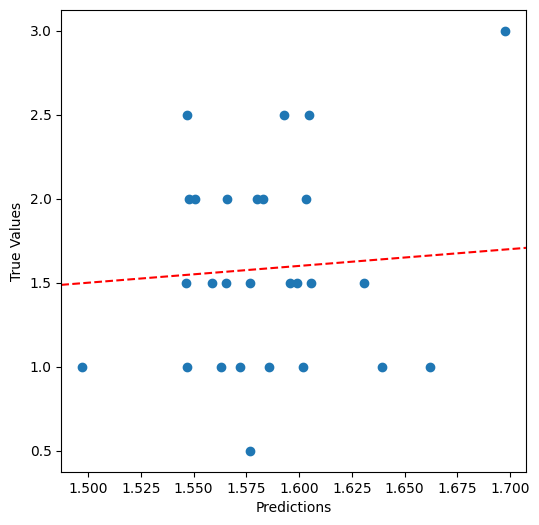

In [91]:
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(df_all[df_all['clf_pred']==1]['reg pred'], df_all[df_all['clf_pred']==1][target_col])
add_identity(ax, color='r', ls='--')
# ax.scatter(stds, train_scores_df['score']-means)
plt.ylabel('True Values')
plt.xlabel('Predictions')

plt.show()

In [96]:
out = pd.read_csv('../lgbm_v2_features0.csv')

In [98]:
out = out.merge(df_all, on='id', how='left')
out.loc[out['clf_pred']==1, 'pred'] = out.loc[out['clf_pred']==1, 'reg pred']

In [99]:
print('OOF metric LGBM = {:.5f}'.format(metrics.mean_squared_error(out[target_col], 
                                                                   out['pred'],
                                                                   squared=False)))

OOF metric LGBM = 0.62799
